In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
from scipy.interpolate import interp2d
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
from Map import ly_noise,heii_noise,civ_noise,lyemissioncube,\
heiiemissioncube,civemissioncube,heiivelocitymap,civvelocitymap,\
heiispec,civspec

In [8]:
def interpolate_grid(x,y,img,xnew,ynew,method='linear'):
    
    interfunc=interp2d(y,x,img,kind=method)
    img_inter=interfunc(ynew,xnew)
    return img_inter

def radiu_profile(x,y):
    
    x_mesh,y_mesh=np.meshgrid(y,x)
    r_mesh=np.sqrt((x_mesh**2)+(y_mesh**2))
    return r_mesh


def velocity_sigma(img_nb,flux_noise,velo,velo_axis):
    
    velo_cube=np.ones((velo_axis.size,velo.shape[0],velo.shape[1]))
    for i in range(velo_axis.size):
        velo_cube[i,:,:]=velo_axis[i]*velo_cube[i,:,:]
    
    v_sigma=(flux_noise/img_nb)*np.sqrt(((velo_cube-velo)**2).sum(axis=0))
    
    return v_sigma

def img_bin(img1,img2,sigma1,sigma2,r_mesh,v1,v2,v_sigma1,v_sigma2,
            nx,ny,delta_x=5,delta_y=5,value1=None,value2=None):
    
    lib1,lib2,r_lib,lib_sigma1,lib_sigma2,lib_v1,lib_v2,lib_vs1,lib_vs2=[],[],[],[],[],[],[],[],[]
    for i in range(nx,img1.shape[0]-nx,nx+delta_x):
        for j in range(ny,img1.shape[1]-ny,ny+delta_y):
            cell01=img1[i-nx:i+nx,j-ny:j+ny]
            cell02=img2[i-nx:i+nx,j-ny:j+ny]
            jud1=np.abs(cell01-value1)>1e-8
            jud2=np.abs(cell02-value2)>1e-8
            cell11=cell01[jud1]
            cell12=cell02[jud2]
            
            scell01=sigma1[i-nx:i+nx,j-ny:j+ny]
            scell02=sigma2[i-nx:i+nx,j-ny:j+ny]
            scell11=scell01[jud1]
            scell12=scell02[jud2]
            
            vcell01=v1[i-nx:i+nx,j-ny:j+ny]
            vcell02=v2[i-nx:i+nx,j-ny:j+ny]
            vcell11=vcell01[jud1]
            vcell12=vcell02[jud2]
            
            vscell01=v_sigma1[i-nx:i+nx,j-ny:j+ny]
            vscell02=v_sigma2[i-nx:i+nx,j-ny:j+ny]
            vscell11=vscell01[jud1]
            vscell12=vscell02[jud2]
            if (cell11.size>0)&(cell12.size>0):
                lib1.append(cell11.mean())
                lib2.append(cell12.mean())
                lib_sigma1.append(np.median(scell11)/np.sqrt(scell11.size))
                lib_sigma2.append(np.median(scell12)/np.sqrt(scell12.size))
                lib_v1.append(np.median(vcell11))
                lib_v2.append(np.median(vcell12))
                lib_vs1.append(np.median(vscell11))
                lib_vs2.append(np.median(vscell12))
                r=r_mesh[i-nx:i+nx,j-ny:j+ny]
                r=r[jud1&jud2]
                r_lib.append(r.mean())
    
    return np.array(lib1),np.array(lib2),np.array(r_lib) \
,np.array(lib_sigma1),np.array(lib_sigma2),np.array(lib_v1),np.array(lib_v2) \
,np.array(lib_vs1),np.array(lib_vs2)

In [11]:
ly_nb=lyemissioncube.optimal_img*1e-17
heii_nb=heiiemissioncube.optimal_img*1e-17
civ_nb=civemissioncube.optimal_img*1e-17
heiivelo=heiivelocitymap.copy()
civvelo=civvelocitymap.copy()

heii_judge=np.ones_like(heii_nb).astype(np.bool)
heii_judge[25:44,9:]=False
civ_judge=np.ones_like(civ_nb).astype(np.bool)
civ_judge[23:46,8:]=False

ly_noise1=ly_noise*1e-17*np.sqrt(lyemissioncube.shape[0])
heii_noise1=heii_noise*1e-17*np.sqrt(heiiemissioncube.shape[0])
civ_noise1=civ_noise*1e-17*np.sqrt(civemissioncube.shape[0])

lysnr=ly_nb/ly_noise1
heiisnr=heii_nb/heii_noise1
civsnr=civ_nb/civ_noise1

heii_v_sigma=velocity_sigma(heiiemissioncube.optimal_img,
                            heii_noise,heiivelocitymap,
                            heiispec)
civ_v_sigma=velocity_sigma(civemissioncube.optimal_img,
                           civ_noise,civvelocitymap,
                           civspec)

ly_nb[lysnr<=3]=3*ly_noise1
heii_nb[(heiisnr<=3)|(heii_judge)]=3*heii_noise1
civ_nb[(civsnr<=3)|(civ_judge)]=3*civ_noise1
heiivelo[(heiisnr<=3)|(heii_judge)]=0
civvelo[(civsnr<=3)|(civ_judge)]=0
heii_v_sigma[(heiisnr<=3)|(heii_judge)]=0
civ_v_sigma[(civsnr<=3)|(civ_judge)]=0


kcwi_ra=heiiemissioncube.ra.to(u.arcsec).value
kcwi_dec=heiiemissioncube.dec.to(u.arcsec).value

In [12]:
dic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/'
h_alpha=np.genfromtxt(dic+'H-alpha_intensity.txt')
h_alpha_ra=np.genfromtxt(dic+'H-alpha_ra.txt')
h_alpha_dec=np.genfromtxt(dic+'H-alpha_dec.txt')-3.5
h_alpha_noise=1.1877882e-18
h_alpha[h_alpha<=0]=3*h_alpha_noise
h_alpha_snr=h_alpha/h_alpha_noise

In [13]:
ra_inter=np.linspace(kcwi_ra.min(),kcwi_ra.max(),400)
dec_inter=np.linspace(kcwi_dec.min(),kcwi_dec.max(),400)

ly_img=interpolate_grid(kcwi_ra,kcwi_dec,ly_nb,ra_inter,dec_inter)
heii_img=interpolate_grid(kcwi_ra,kcwi_dec,heii_nb,ra_inter,dec_inter)
civ_img=interpolate_grid(kcwi_ra,kcwi_dec,civ_nb,ra_inter,dec_inter)
h_alpha_img=interpolate_grid(h_alpha_dec,h_alpha_ra,h_alpha,ra_inter,dec_inter)


lysnr=interpolate_grid(kcwi_ra,kcwi_dec,lysnr,ra_inter,dec_inter)
civsnr=interpolate_grid(kcwi_ra,kcwi_dec,civsnr,ra_inter,dec_inter)
heiisnr=interpolate_grid(kcwi_ra,kcwi_dec,heiisnr,ra_inter,dec_inter)
h_alpha_snr=interpolate_grid(h_alpha_dec,h_alpha_ra,h_alpha_snr,ra_inter,dec_inter)

heiivelo=interpolate_grid(kcwi_ra,kcwi_dec,heiivelo,ra_inter,dec_inter)
civvelo=interpolate_grid(kcwi_ra,kcwi_dec,civvelo,ra_inter,dec_inter)

heiivsigma=interpolate_grid(kcwi_ra,kcwi_dec,heii_v_sigma,ra_inter,dec_inter)
civvsigma=interpolate_grid(kcwi_ra,kcwi_dec,civ_v_sigma,ra_inter,dec_inter)

In [14]:
ly_img=np.rot90(ly_img)[:,::-1]
heii_img=np.rot90(heii_img)[:,::-1]
civ_img=np.rot90(civ_img)[:,::-1]
h_alpha_img=h_alpha_img[:,::-1]

heiivelo=np.rot90(heiivelo)[:,::-1]
civvelo=np.rot90(civvelo)[:,::-1]
heiivsigma=np.rot90(heiivsigma)[:,::-1]
civvsigma=np.rot90(civvsigma)[:,::-1]

lysnr=ly_img/ly_noise1
heiisnr=heii_img/heii_noise1
civsnr=civ_img/civ_noise1
h_alpha_snr=h_alpha_img/h_alpha_noise

In [15]:
heii_ly=heii_img/ly_img
civ_ly=civ_img/ly_img

sigma_heii_ly=heii_ly*np.sqrt((1/heiisnr**2)+(1/lysnr**2))
sigma_civ_ly=civ_ly*np.sqrt((1/civsnr**2)+(1/lysnr**2))

heii_h=heii_img/h_alpha_img
civ_h=civ_img/h_alpha_img

sigma_heii_h=heii_h*np.sqrt((1/heiisnr**2)+(1/h_alpha_snr**2))
sigma_civ_h=civ_h*np.sqrt((1/civsnr**2)+(1/h_alpha_snr**2))

In [10]:
r_mesh_h=radiu_profile(ra_inter,dec_inter)
value_heii,_=stats.mode(heii_h)
value_heii=value_heii[0,0]
value_civ,_=stats.mode(civ_h)
value_civ=value_civ[0,0]
results=img_bin(heii_h,civ_h,sigma_heii_h,sigma_civ_h,
                r_mesh_h,heiivelo,civvelo,heiivsigma,civvsigma,
                10,10,21,21,value_heii,value_civ)#8,8,20,20//13,13,27,27
heii_h,civ_h,r_h,sigma_heii_h,sigma_civ_h,heii_v,civ_v,heii_vs,civ_vs=results
r_h=r_h*8.2

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
dic1='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/model_v2/shock/'
model_shock_list=os.listdir(dic1)
model_shock_list=np.array([i for i in model_shock_list if '.csv' in i])
metal_Z=np.array([name[2:7] for name in model_shock_list]).astype(np.float64)

data_list=pd.DataFrame({'name':model_shock_list,'Z':metal_Z})
dataframe=[pd.read_csv(dic1+data_list['name'][j]) for j in range(data_list['name'].shape[0])]
DATA=pd.concat(dataframe)
DATA['heii_h']=DATA['HeII']/DATA['h_alpha']
DATA['civ_h']=DATA['CIV']/DATA['h_alpha']
DATA['z']=DATA['z']/0.0183#convert to solar metallicity

In [13]:
DATA=DATA[(DATA['ref']=='Allen08')]

In [14]:
np.sort(pd.unique(DATA['z']))

array([0.18032787, 0.35519126, 1.        , 1.95628415])

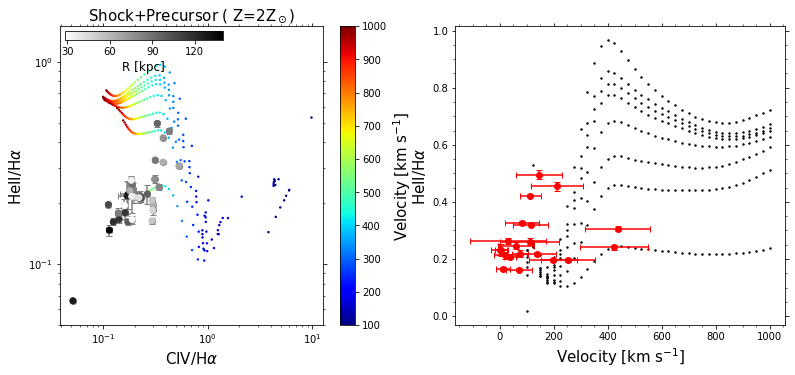

In [19]:
data=DATA[(np.abs(DATA['z']-1.95628415)<1e-2)]

fig,ax=plt.subplots(1,2)
img=ax[0].scatter(data['civ_h'],data['heii_h'],s=2,c=data['v'],cmap='jet')

cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'Velocity [km s$^{-1}$]',fontsize=15)

ax[0].errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,
               fmt='o',capsize=3,c='gray')#,mew=0,zorder=0)
img=ax[0].scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)

cbar_scatter_ax=inset_axes(ax[0],width="60%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,150,30), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 

ax[0].set_ylim(0.05,1.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_title(r'Shock+Precursor ( Z=2Z$_{\rm \odot}$)',fontsize=15)
ax[0].set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax[0].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[0].tick_params(axis='both', which='both',top=True,right=True)


x=np.abs(heii_v[heii_v!=0])*np.sqrt(3)
y=heii_h[heii_v!=0]
xerr=heii_vs[heii_v!=0]*np.sqrt(3)
yerr=2*sigma_heii_h[heii_v!=0]
ax[1].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',capsize=3,color='red')
ax[1].scatter(data['v'],data['heii_h'],s=2,c='black')
ax[1].set_xlabel(r'Velocity [km s$^{-1}$]',fontsize=15)
ax[1].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()



plt.rcParams['figure.figsize'] = [13, 5.5]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
# plt.savefig(savdic+'H_alpha_SP.png',dpi=300)

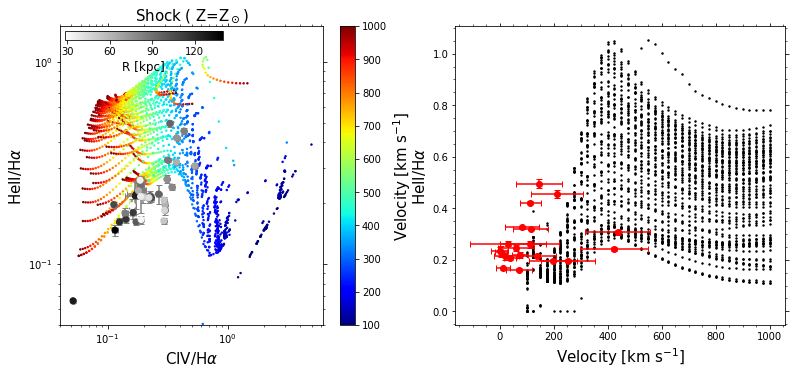

In [22]:
data=DATA[(np.abs(DATA['z']-1.)<1e-2)]

fig,ax=plt.subplots(1,2)
img=ax[0].scatter(data['civ_h'],data['heii_h'],s=2,c=data['v'],cmap='jet')

cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'Velocity [km s$^{-1}$]',fontsize=15)

ax[0].errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,
               fmt='o',capsize=3,c='gray')#,mew=0,zorder=0)
img=ax[0].scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)

cbar_scatter_ax=inset_axes(ax[0],width="60%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,150,30), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 

ax[0].set_ylim(0.05,1.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_title(r'Shock ( Z=Z$_{\rm \odot}$)',fontsize=15)
ax[0].set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax[0].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[0].tick_params(axis='both', which='both',top=True,right=True)


x=np.abs(heii_v[heii_v!=0])*np.sqrt(3)
y=heii_h[heii_v!=0]
xerr=heii_vs[heii_v!=0]*np.sqrt(3)
yerr=2*sigma_heii_h[heii_v!=0]
ax[1].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',capsize=3,color='red')
ax[1].scatter(data['v'],data['heii_h'],s=2,c='black')
ax[1].set_xlabel(r'Velocity [km s$^{-1}$]',fontsize=15)
ax[1].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()



plt.rcParams['figure.figsize'] = [13, 5.5]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
# plt.savefig(savdic+'H_alpha_SP.png',dpi=300)

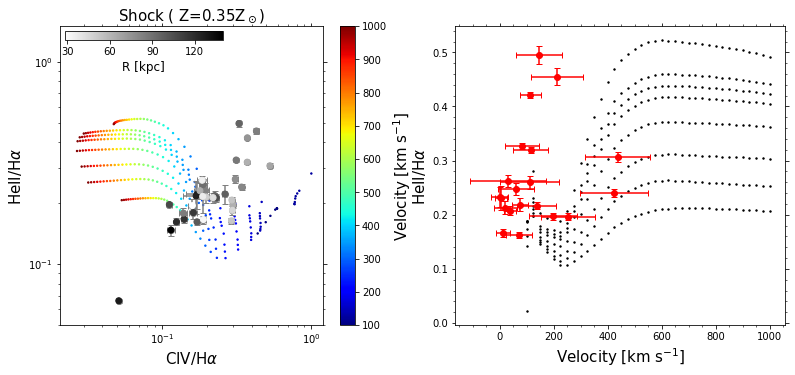

In [23]:
data=DATA[(np.abs(DATA['z']-0.35519126)<1e-2)]

fig,ax=plt.subplots(1,2)
img=ax[0].scatter(data['civ_h'],data['heii_h'],s=2,c=data['v'],cmap='jet')

cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'Velocity [km s$^{-1}$]',fontsize=15)

ax[0].errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,
               fmt='o',capsize=3,c='gray')#,mew=0,zorder=0)
img=ax[0].scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)

cbar_scatter_ax=inset_axes(ax[0],width="60%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,150,30), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 

ax[0].set_ylim(0.05,1.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_title(r'Shock ( Z=0.35Z$_{\rm \odot}$)',fontsize=15)
ax[0].set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax[0].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[0].tick_params(axis='both', which='both',top=True,right=True)


x=np.abs(heii_v[heii_v!=0])*np.sqrt(3)
y=heii_h[heii_v!=0]
xerr=heii_vs[heii_v!=0]*np.sqrt(3)
yerr=2*sigma_heii_h[heii_v!=0]
ax[1].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',capsize=3,color='red')
ax[1].scatter(data['v'],data['heii_h'],s=2,c='black')
ax[1].set_xlabel(r'Velocity [km s$^{-1}$]',fontsize=15)
ax[1].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()



plt.rcParams['figure.figsize'] = [13, 5.5]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
# plt.savefig(savdic+'H_alpha_SP.png',dpi=300)

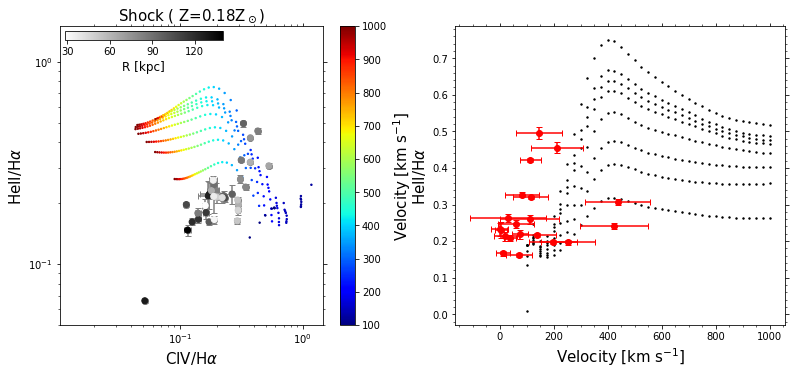

In [25]:
data=DATA[(np.abs(DATA['z']-0.18032787)<1e-2)]

fig,ax=plt.subplots(1,2)
img=ax[0].scatter(data['civ_h'],data['heii_h'],s=2,c=data['v'],cmap='jet')

cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'Velocity [km s$^{-1}$]',fontsize=15)

ax[0].errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,
               fmt='o',capsize=3,c='gray')#,mew=0,zorder=0)
img=ax[0].scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)

cbar_scatter_ax=inset_axes(ax[0],width="60%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,150,30), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 

ax[0].set_ylim(0.05,1.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_title(r'Shock ( Z=0.18Z$_{\rm \odot}$)',fontsize=15)
ax[0].set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax[0].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[0].tick_params(axis='both', which='both',top=True,right=True)


x=np.abs(heii_v[heii_v!=0])*np.sqrt(3)
y=heii_h[heii_v!=0]
xerr=heii_vs[heii_v!=0]*np.sqrt(3)
yerr=2*sigma_heii_h[heii_v!=0]
ax[1].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',capsize=3,color='red')
ax[1].scatter(data['v'],data['heii_h'],s=2,c='black')
ax[1].set_xlabel(r'Velocity [km s$^{-1}$]',fontsize=15)
ax[1].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()



plt.rcParams['figure.figsize'] = [13, 5.5]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
# plt.savefig(savdic+'H_alpha_SP.png',dpi=300)

In [26]:
dic1='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/model_v2/shock/'
model_shock_list=os.listdir(dic1)
model_shock_list=np.array([i for i in model_shock_list if '.csv' in i])
metal_Z=np.array([name[2:7] for name in model_shock_list]).astype(np.float64)

data_list=pd.DataFrame({'name':model_shock_list,'Z':metal_Z})
dataframe=[pd.read_csv(dic1+data_list['name'][j]) for j in range(data_list['name'].shape[0])]
DATA=pd.concat(dataframe)
DATA['heii_h']=DATA['HeII']/DATA['h_alpha']
DATA['civ_h']=DATA['CIV']/DATA['h_alpha']
DATA['z']=DATA['z']/0.0183#convert to solar metallicity

In [27]:
DATA=DATA[(DATA['ref']=='Gutkin16')&(DATA['script']=='shock_s5_m5113.sh')]

In [29]:
np.sort(pd.unique(DATA['z']))

array([0.00546448, 0.01092896, 0.0273224 , 0.05464481, 0.10928962,
       0.21857923, 0.32786885, 0.43715847, 0.54644809, 0.7704918 ,
       0.82513661, 0.91803279, 1.09836066, 1.62295082, 2.19125683])

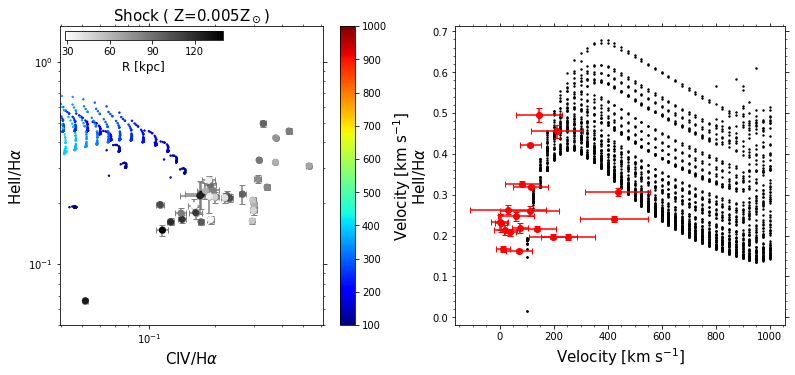

In [30]:
data=DATA[(np.abs(DATA['z']-0.00546448)<1e-2)]

fig,ax=plt.subplots(1,2)
img=ax[0].scatter(data['civ_h'],data['heii_h'],s=2,c=data['v'],cmap='jet')

cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'Velocity [km s$^{-1}$]',fontsize=15)

ax[0].errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,
               fmt='o',capsize=3,c='gray')#,mew=0,zorder=0)
img=ax[0].scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)

cbar_scatter_ax=inset_axes(ax[0],width="60%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,150,30), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 

ax[0].set_ylim(0.05,1.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_title(r'Shock ( Z=0.005Z$_{\rm \odot}$)',fontsize=15)
ax[0].set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax[0].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[0].tick_params(axis='both', which='both',top=True,right=True)


x=np.abs(heii_v[heii_v!=0])*np.sqrt(3)
y=heii_h[heii_v!=0]
xerr=heii_vs[heii_v!=0]*np.sqrt(3)
yerr=2*sigma_heii_h[heii_v!=0]
ax[1].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',capsize=3,color='red')
ax[1].scatter(data['v'],data['heii_h'],s=2,c='black')
ax[1].set_xlabel(r'Velocity [km s$^{-1}$]',fontsize=15)
ax[1].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()



plt.rcParams['figure.figsize'] = [13, 5.5]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
# plt.savefig(savdic+'H_alpha_SP.png',dpi=300)

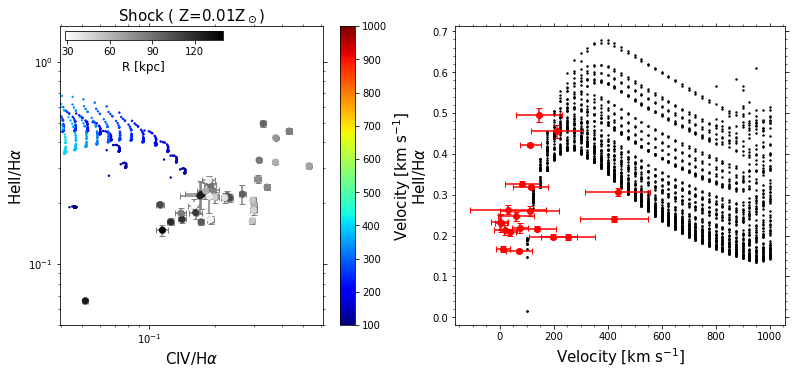

In [31]:
data=DATA[(np.abs(DATA['z']-0.01092896)<1e-2)]

fig,ax=plt.subplots(1,2)
img=ax[0].scatter(data['civ_h'],data['heii_h'],s=2,c=data['v'],cmap='jet')

cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'Velocity [km s$^{-1}$]',fontsize=15)

ax[0].errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,
               fmt='o',capsize=3,c='gray')#,mew=0,zorder=0)
img=ax[0].scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)

cbar_scatter_ax=inset_axes(ax[0],width="60%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,150,30), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 

ax[0].set_ylim(0.05,1.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_title(r'Shock ( Z=0.01Z$_{\rm \odot}$)',fontsize=15)
ax[0].set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax[0].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[0].tick_params(axis='both', which='both',top=True,right=True)


x=np.abs(heii_v[heii_v!=0])*np.sqrt(3)
y=heii_h[heii_v!=0]
xerr=heii_vs[heii_v!=0]*np.sqrt(3)
yerr=2*sigma_heii_h[heii_v!=0]
ax[1].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',capsize=3,color='red')
ax[1].scatter(data['v'],data['heii_h'],s=2,c='black')
ax[1].set_xlabel(r'Velocity [km s$^{-1}$]',fontsize=15)
ax[1].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()



plt.rcParams['figure.figsize'] = [13, 5.5]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
# plt.savefig(savdic+'H_alpha_SP.png',dpi=300)

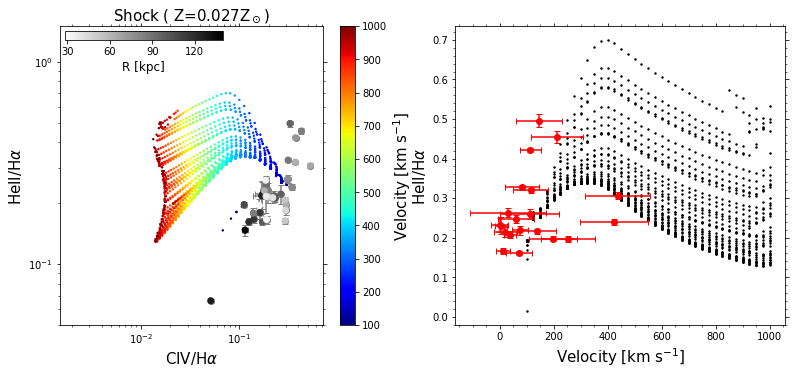

In [32]:
data=DATA[(np.abs(DATA['z']-0.0273224)<1e-2)]

fig,ax=plt.subplots(1,2)
img=ax[0].scatter(data['civ_h'],data['heii_h'],s=2,c=data['v'],cmap='jet')

cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'Velocity [km s$^{-1}$]',fontsize=15)

ax[0].errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,
               fmt='o',capsize=3,c='gray')#,mew=0,zorder=0)
img=ax[0].scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)

cbar_scatter_ax=inset_axes(ax[0],width="60%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,150,30), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 

ax[0].set_ylim(0.05,1.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_title(r'Shock ( Z=0.027Z$_{\rm \odot}$)',fontsize=15)
ax[0].set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax[0].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[0].tick_params(axis='both', which='both',top=True,right=True)


x=np.abs(heii_v[heii_v!=0])*np.sqrt(3)
y=heii_h[heii_v!=0]
xerr=heii_vs[heii_v!=0]*np.sqrt(3)
yerr=2*sigma_heii_h[heii_v!=0]
ax[1].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',capsize=3,color='red')
ax[1].scatter(data['v'],data['heii_h'],s=2,c='black')
ax[1].set_xlabel(r'Velocity [km s$^{-1}$]',fontsize=15)
ax[1].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()



plt.rcParams['figure.figsize'] = [13, 5.5]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
# plt.savefig(savdic+'H_alpha_SP.png',dpi=300)

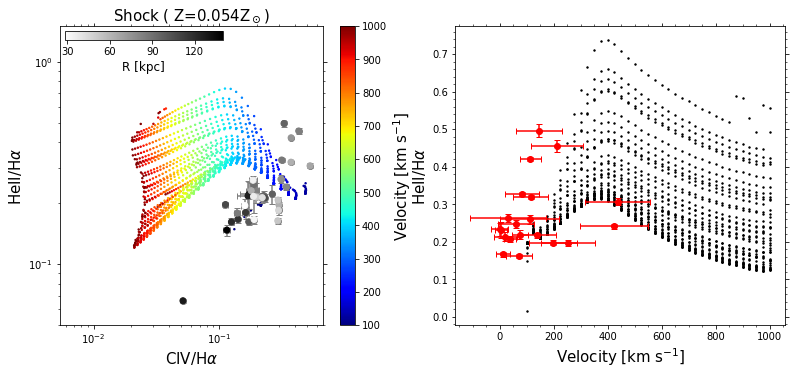

In [33]:
data=DATA[(np.abs(DATA['z']-0.05464481)<1e-2)]

fig,ax=plt.subplots(1,2)
img=ax[0].scatter(data['civ_h'],data['heii_h'],s=2,c=data['v'],cmap='jet')

cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'Velocity [km s$^{-1}$]',fontsize=15)

ax[0].errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,
               fmt='o',capsize=3,c='gray')#,mew=0,zorder=0)
img=ax[0].scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)

cbar_scatter_ax=inset_axes(ax[0],width="60%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,150,30), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 

ax[0].set_ylim(0.05,1.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_title(r'Shock ( Z=0.054Z$_{\rm \odot}$)',fontsize=15)
ax[0].set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax[0].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[0].tick_params(axis='both', which='both',top=True,right=True)


x=np.abs(heii_v[heii_v!=0])*np.sqrt(3)
y=heii_h[heii_v!=0]
xerr=heii_vs[heii_v!=0]*np.sqrt(3)
yerr=2*sigma_heii_h[heii_v!=0]
ax[1].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',capsize=3,color='red')
ax[1].scatter(data['v'],data['heii_h'],s=2,c='black')
ax[1].set_xlabel(r'Velocity [km s$^{-1}$]',fontsize=15)
ax[1].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()



plt.rcParams['figure.figsize'] = [13, 5.5]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
# plt.savefig(savdic+'H_alpha_SP.png',dpi=300)

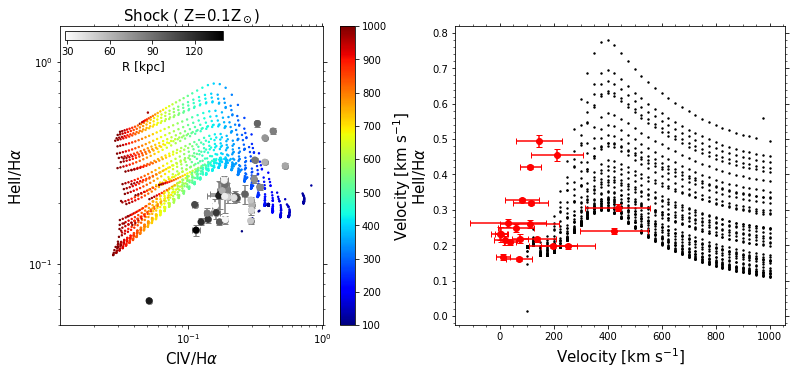

In [35]:
data=DATA[(np.abs(DATA['z']-0.10928962)<1e-2)]

fig,ax=plt.subplots(1,2)
img=ax[0].scatter(data['civ_h'],data['heii_h'],s=2,c=data['v'],cmap='jet')

cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'Velocity [km s$^{-1}$]',fontsize=15)

ax[0].errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,
               fmt='o',capsize=3,c='gray')#,mew=0,zorder=0)
img=ax[0].scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)

cbar_scatter_ax=inset_axes(ax[0],width="60%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,150,30), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 

ax[0].set_ylim(0.05,1.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_title(r'Shock ( Z=0.1Z$_{\rm \odot}$)',fontsize=15)
ax[0].set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax[0].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[0].tick_params(axis='both', which='both',top=True,right=True)


x=np.abs(heii_v[heii_v!=0])*np.sqrt(3)
y=heii_h[heii_v!=0]
xerr=heii_vs[heii_v!=0]*np.sqrt(3)
yerr=2*sigma_heii_h[heii_v!=0]
ax[1].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',capsize=3,color='red')
ax[1].scatter(data['v'],data['heii_h'],s=2,c='black')
ax[1].set_xlabel(r'Velocity [km s$^{-1}$]',fontsize=15)
ax[1].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()



plt.rcParams['figure.figsize'] = [13, 5.5]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
# plt.savefig(savdic+'H_alpha_SP.png',dpi=300)

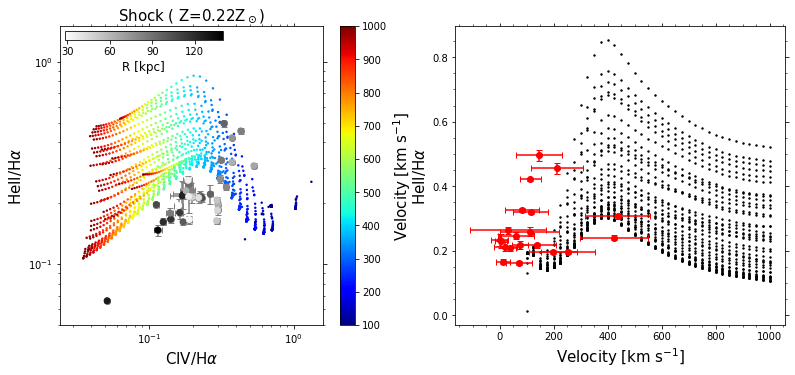

In [37]:
data=DATA[(np.abs(DATA['z']-0.21857923)<1e-2)]

fig,ax=plt.subplots(1,2)
img=ax[0].scatter(data['civ_h'],data['heii_h'],s=2,c=data['v'],cmap='jet')

cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'Velocity [km s$^{-1}$]',fontsize=15)

ax[0].errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,
               fmt='o',capsize=3,c='gray')#,mew=0,zorder=0)
img=ax[0].scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)

cbar_scatter_ax=inset_axes(ax[0],width="60%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,150,30), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 

ax[0].set_ylim(0.05,1.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_title(r'Shock ( Z=0.22Z$_{\rm \odot}$)',fontsize=15)
ax[0].set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax[0].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[0].tick_params(axis='both', which='both',top=True,right=True)


x=np.abs(heii_v[heii_v!=0])*np.sqrt(3)
y=heii_h[heii_v!=0]
xerr=heii_vs[heii_v!=0]*np.sqrt(3)
yerr=2*sigma_heii_h[heii_v!=0]
ax[1].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',capsize=3,color='red')
ax[1].scatter(data['v'],data['heii_h'],s=2,c='black')
ax[1].set_xlabel(r'Velocity [km s$^{-1}$]',fontsize=15)
ax[1].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()


plt.rcParams['figure.figsize'] = [13, 5.5]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
# plt.savefig(savdic+'H_alpha_SP.png',dpi=300)

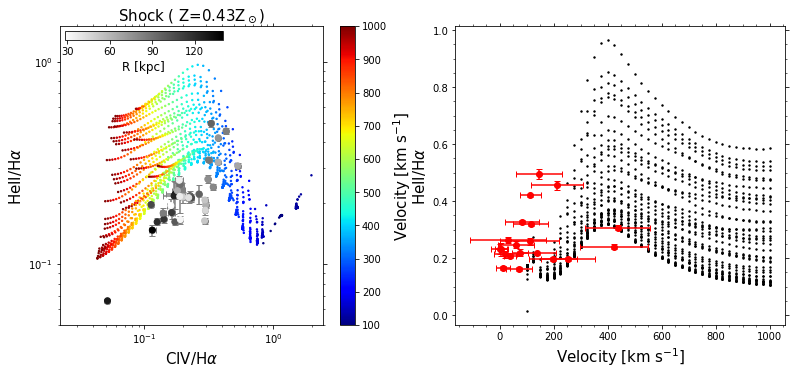

In [39]:
data=DATA[(np.abs(DATA['z']-0.43715847)<1e-2)]

fig,ax=plt.subplots(1,2)
img=ax[0].scatter(data['civ_h'],data['heii_h'],s=2,c=data['v'],cmap='jet')

cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'Velocity [km s$^{-1}$]',fontsize=15)

ax[0].errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,
               fmt='o',capsize=3,c='gray')#,mew=0,zorder=0)
img=ax[0].scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)

cbar_scatter_ax=inset_axes(ax[0],width="60%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,150,30), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 

ax[0].set_ylim(0.05,1.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_title(r'Shock ( Z=0.43Z$_{\rm \odot}$)',fontsize=15)
ax[0].set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax[0].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[0].tick_params(axis='both', which='both',top=True,right=True)


x=np.abs(heii_v[heii_v!=0])*np.sqrt(3)
y=heii_h[heii_v!=0]
xerr=heii_vs[heii_v!=0]*np.sqrt(3)
yerr=2*sigma_heii_h[heii_v!=0]
ax[1].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',capsize=3,color='red')
ax[1].scatter(data['v'],data['heii_h'],s=2,c='black')
ax[1].set_xlabel(r'Velocity [km s$^{-1}$]',fontsize=15)
ax[1].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()


plt.rcParams['figure.figsize'] = [13, 5.5]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
# plt.savefig(savdic+'H_alpha_SP.png',dpi=300)

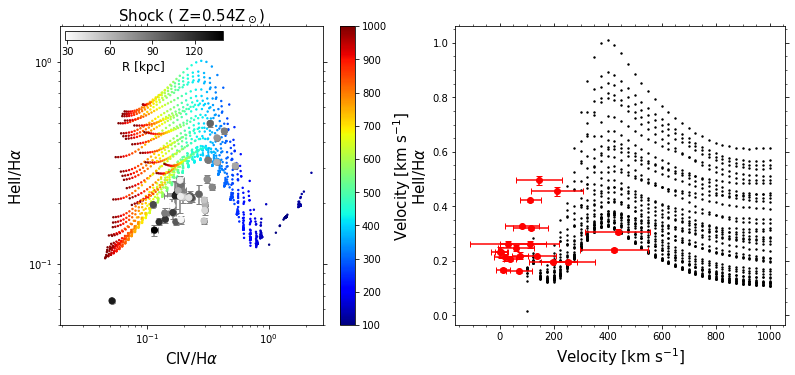

In [40]:
data=DATA[(np.abs(DATA['z']-0.54644809)<1e-2)]

fig,ax=plt.subplots(1,2)
img=ax[0].scatter(data['civ_h'],data['heii_h'],s=2,c=data['v'],cmap='jet')

cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'Velocity [km s$^{-1}$]',fontsize=15)

ax[0].errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,
               fmt='o',capsize=3,c='gray')#,mew=0,zorder=0)
img=ax[0].scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)

cbar_scatter_ax=inset_axes(ax[0],width="60%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,150,30), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 

ax[0].set_ylim(0.05,1.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_title(r'Shock ( Z=0.54Z$_{\rm \odot}$)',fontsize=15)
ax[0].set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax[0].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[0].tick_params(axis='both', which='both',top=True,right=True)


x=np.abs(heii_v[heii_v!=0])*np.sqrt(3)
y=heii_h[heii_v!=0]
xerr=heii_vs[heii_v!=0]*np.sqrt(3)
yerr=2*sigma_heii_h[heii_v!=0]
ax[1].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',capsize=3,color='red')
ax[1].scatter(data['v'],data['heii_h'],s=2,c='black')
ax[1].set_xlabel(r'Velocity [km s$^{-1}$]',fontsize=15)
ax[1].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()


plt.rcParams['figure.figsize'] = [13, 5.5]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
# plt.savefig(savdic+'H_alpha_SP.png',dpi=300)

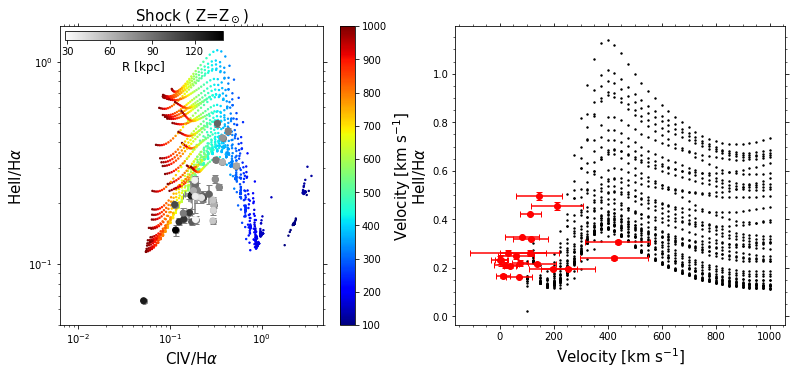

In [42]:
data=DATA[(np.abs(DATA['z']-1.09836066)<1e-2)]

fig,ax=plt.subplots(1,2)
img=ax[0].scatter(data['civ_h'],data['heii_h'],s=2,c=data['v'],cmap='jet')

cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'Velocity [km s$^{-1}$]',fontsize=15)

ax[0].errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,
               fmt='o',capsize=3,c='gray')#,mew=0,zorder=0)
img=ax[0].scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)

cbar_scatter_ax=inset_axes(ax[0],width="60%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,150,30), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 

ax[0].set_ylim(0.05,1.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_title(r'Shock ( Z=Z$_{\rm \odot}$)',fontsize=15)
ax[0].set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax[0].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[0].tick_params(axis='both', which='both',top=True,right=True)


x=np.abs(heii_v[heii_v!=0])*np.sqrt(3)
y=heii_h[heii_v!=0]
xerr=heii_vs[heii_v!=0]*np.sqrt(3)
yerr=2*sigma_heii_h[heii_v!=0]
ax[1].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',capsize=3,color='red')
ax[1].scatter(data['v'],data['heii_h'],s=2,c='black')
ax[1].set_xlabel(r'Velocity [km s$^{-1}$]',fontsize=15)
ax[1].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()


plt.rcParams['figure.figsize'] = [13, 5.5]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
# plt.savefig(savdic+'H_alpha_SP.png',dpi=300)

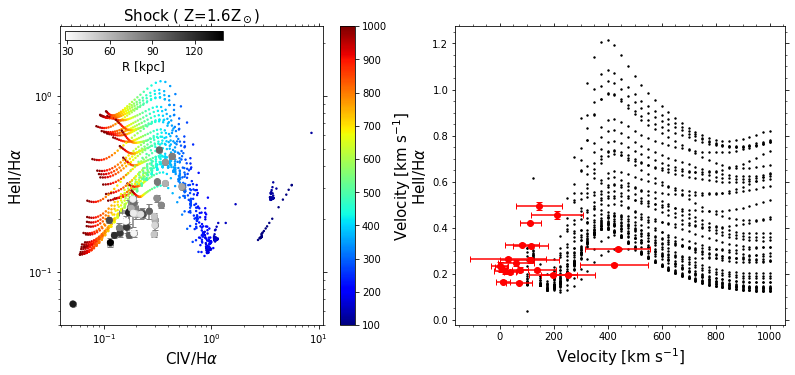

In [46]:
data=DATA[(np.abs(DATA['z']-1.62295082)<1e-2)]

fig,ax=plt.subplots(1,2)
img=ax[0].scatter(data['civ_h'],data['heii_h'],s=2,c=data['v'],cmap='jet')

cbar=plt.colorbar(img,ax=ax[0])
cbar.ax.set_ylabel(r'Velocity [km s$^{-1}$]',fontsize=15)

ax[0].errorbar(civ_h,heii_h,xerr=2*sigma_civ_h,yerr=2*sigma_heii_h,
               fmt='o',capsize=3,c='gray')#,mew=0,zorder=0)
img=ax[0].scatter(civ_h,heii_h,c=r_h,cmap='gray_r',zorder=100)

cbar_scatter_ax=inset_axes(ax[0],width="60%", height="3%", loc=2)
cbar_scatter=fig.colorbar(img,cax=cbar_scatter_ax, ticks=np.arange(0,150,30), orientation='horizontal')
cbar_scatter.ax.set_xlabel(r'R [kpc]',fontsize=12) 

ax[0].set_ylim(0.05,2.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_title(r'Shock ( Z=1.6Z$_{\rm \odot}$)',fontsize=15)
ax[0].set_xlabel(r'CIV/H$\alpha$',fontsize=15)
ax[0].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[0].tick_params(axis='both', which='both',top=True,right=True)


x=np.abs(heii_v[heii_v!=0])*np.sqrt(3)
y=heii_h[heii_v!=0]
xerr=heii_vs[heii_v!=0]*np.sqrt(3)
yerr=2*sigma_heii_h[heii_v!=0]
ax[1].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',capsize=3,color='red')
ax[1].scatter(data['v'],data['heii_h'],s=2,c='black')
ax[1].set_xlabel(r'Velocity [km s$^{-1}$]',fontsize=15)
ax[1].set_ylabel(r'HeII/H$\alpha$',fontsize=15)
ax[1].tick_params(axis='both', which='both',top=True,right=True)
ax[1].minorticks_on()


plt.rcParams['figure.figsize'] = [13, 5.5]
plt.show()
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
# plt.savefig(savdic+'H_alpha_SP.png',dpi=300)